In [1]:
import numpy as np 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import re
import random
import math
import pandas as pd 
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets

#Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Import Files

In [27]:
o = os.getcwd()

data = pd.read_csv(o + "\\..\\data\\cases_train_processed.csv", parse_dates = True)
data_test = pd.read_csv(o + "\\..\\data\\cases_test_processed.csv", parse_dates=True)
plot_path = o + "\\..\\plots\\"
results_path = o + "\\..\\results\\"

'''
# For Mac/Linux
data = pd.read_csv(o + "/../data/cases_train_processed.csv", parse_dates = True)
data_test = pd.read_csv(o + "/../data/cases_test_processed.csv", parse_dates = True)
plot_path = o + "/../plots/"
results_path = o + "/../results/"
'''

'\n# For Mac/Linux\ndata = pd.read_csv(o + "/../data/cases_train_processed.csv", parse_dates = True)\ndata_test = pd.read_csv(o + "/../data/cases_test_processed.csv", parse_dates = True)\nplot_path = o + "/../plots/"\nresults_path = o + "/../results/"\n'

## Categorize Functions

In [8]:
# converts string Series into a cataegorized int series for data analysis
def categorize_column(data):
    i = 0
    for value in tqdm(data.unique()):
        data.replace(value, i, inplace = True)
        i += 1
    data = data.apply(pd.to_numeric)
    return data

# converts string Series into a cataegorized int series1 for data analysis
def categorize_outcome(data):
    data = data.map({'nonhospitalized':0, 'deceased':1, 'recovered':2, 'hospitalized':3},na_action ='ignore')
    data = data.apply(pd.to_numeric)
    return data

## Data Cleanup Functions

In [9]:
def cleanup(data):
    data = data.drop(columns=['province', 'country'])
    data['sex'] = categorize_column(data['sex'])
    data['outcome'] = categorize_outcome(data['outcome'])
    data['Combined_Key'] = categorize_column(data['Combined_Key'])
    return data

In [10]:
data = cleanup(data)
data_test = cleanup(data_test)

100%|██████████| 409/409 [00:03<00:00, 103.04it/s]


## Build and Run AdaBoostClassifier

In [21]:
abc  = AdaBoostClassifier()
params = {'n_estimators': [75,100], 'learning_rate': [2]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scoring = {'Overall_Accuracy': metrics.make_scorer(metrics.accuracy_score),
           'Overall_Recall': metrics.make_scorer(metrics.recall_score, average = 'macro'),
           'F1_Deceased': metrics.make_scorer(metrics.f1_score, labels=[1], average= 'micro'),
           'Recall_Deceased': metrics.make_scorer(metrics.recall_score, labels = [1], average = 'micro') }

X = data.drop(columns='outcome')
y = data['outcome']

#n_scores = cross_val_score(abc, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
gs = GridSearchCV(abc, param_grid = params, scoring= scoring, cv=cv, n_jobs=-1, refit = 'Overall_Accuracy')

In [22]:
gs.fit(X,y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [2], 'n_estimators': [75, 100]},
             refit='Overall_Accuracy',
             scoring={'F1_Deceased': make_scorer(f1_score, labels=[1], average=micro),
                      'Overall_Accuracy': make_scorer(accuracy_score),
                      'Overall_Recall': make_scorer(recall_score, average=macro),
                      'Recall_Deceased': make_scorer(recall_score, labels=[1], average=micro)})

In [23]:
gs.cv_results_

{'mean_fit_time': array([31.71422671, 38.70438593]),
 'std_fit_time': array([2.44542226, 7.71244231]),
 'mean_score_time': array([2.39608394, 2.32227804]),
 'std_score_time': array([0.39168789, 0.8917298 ]),
 'param_learning_rate': masked_array(data=[2, 2],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[75, 100],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 2, 'n_estimators': 75},
  {'learning_rate': 2, 'n_estimators': 100}],
 'split0_test_Overall_Accuracy': array([0.70320573, 0.65392575]),
 'split1_test_Overall_Accuracy': array([0.70283961, 0.73012128]),
 'split2_test_Overall_Accuracy': array([0.63936087, 0.72224795]),
 'split3_test_Overall_Accuracy': array([0.70217385, 0.73009234]),
 'split4_test_Overall_Accuracy': array([0.70317249, 0.73017918]),
 'split5_test_Overall_Accuracy': array([0.70418988, 0.73040017]),
 'split6_test_Overal

In [88]:
metrics.accuracy_score(y.values, abc.predict(x))

0.7008025298868209

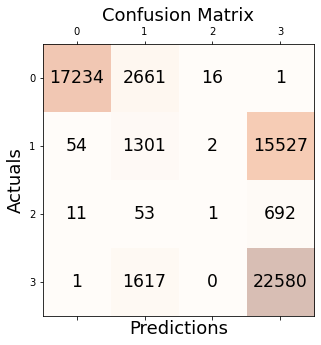

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()    